This notebook shows how to train a Transparency by Design network (TbD-net) on the CLEVR dataset. Training for CoGenT can be done in much the same manner, simply changing the training and validation loaders and updating the evaluation code to evaluate over Condition A and Condition B.

In [1]:
from pathlib import Path

import torch
import torch.optim as optim
import numpy as np

from utils.clevr import load_vocab, ClevrDataLoaderNumpy, ClevrDataLoaderH5
from tbd.module_net import TbDNet

We want to run on CUDA if we have CUDA support so that we can train our model in a reasonable amount of time. We're going to define a convenience function that wraps `torch.autograd.Variable` to automatically push the provided tensor onto the GPU if we can. This seamlessly provides support for CPU and GPU versions without having to write a bunch of CUDA checks.

In [2]:
cuda_available = torch.cuda.is_available()
def Variable(tensor):
    if cuda_available:
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)

The first step is to create our model.

We first load the `vocab` file, which holds a list of all the modules we're going to need. We then pass the vocab into our `TbDNet`, which creates an appropriate neural module for each operation in the vocab.

In [3]:
vocab = load_vocab(Path('data/vocab.json'))

# to train on 14x14 feature maps, pass feature_dim=(1024, 14, 14) to TbDNet
tbd_net = TbDNet(vocab)
if cuda_available:
    tbd_net.cuda()

Next up, we need to load our data.

The `use_numpy_format` flag indicates whether we're loading data using npy files or HDF5 files.

We create the appropriate `DataLoader` objects depending on the choice.

In [4]:
use_numpy_format = True

if use_numpy_format:
    train_loader_kwargs = {
        'question_np': Path('data/training/train_questions.npy'),
        'image_idx_np': Path('data/training/train_image_idxs.npy'),
        'program_np': Path('data/training/train_programs.npy'),
        'feature_np': Path('data/train_features_hres.npy'),
        'answer_np': Path('data/training/train_answers.npy'),
        'batch_size': 128,
        'num_workers': 2,
        'shuffle': True
    }

    val_loader_kwargs = {
        'question_np': Path('data/validation/val_questions.npy'),
        'image_idx_np': Path('data/validation/val_image_idxs.npy'),
        'program_np': Path('data/validation/val_programs.npy'),
        'feature_np': Path('clevr-iep/data/val_features_hres.npy'),
        'answer_np': Path('data/validation/val_answers.npy'),
        'batch_size': 128,
        'num_workers': 2,
        'shuffle': False
    }
    
    train_loader = ClevrDataLoaderNumpy(**train_loader_kwargs)
    val_loader = ClevrDataLoaderNumpy(**val_loader_kwargs)
else:
    train_loader_kwargs = {
        'question_h5': Path('data/training/train_questions.h5'),
        'feature_h5': Path('data/training/train_features_hres.h5'),
        'batch_size': 128,
        'num_workers': 2,
        'shuffle': True
    }
    val_loader_kwargs = {
        'question_h5': Path('data/validation/val_questions.h5'),
        'feature_h5': Path('data/validation/val_features_hres.h5'),
        'batch_size': 128,
        'num_workers': 2,
        'shuffle': False
    }
    
    train_loader = ClevrDataLoaderH5(**train_loader_kwargs)
    val_loader = ClevrDataLoaderH5(**val_loader_kwargs)

Reading features from  data/train_features_hres.npy
Reading questions from  data/training/train_questions.npy
Reading image indices from data/training/train_image_idxs.npy
Reading programs from data/training/train_programs.npy
Reading answers from data/training/train_answers.npy
Reading features from  data/val_features_hres.npy
Reading questions from  data/validation/val_questions.npy
Reading image indices from data/validation/val_image_idxs.npy
Reading programs from data/validation/val_programs.npy
Reading answers from data/validation/val_answers.npy


The answer format we prefer is different from that of Justin Johson *et al.*

Their answers are sorted according to ASCII value, while we group by answer type and sort these alphabetically. Note that we have fewer answers than them, because we do not list the special tokens `<NULL>`, `<START>`, `<END>`, and `<UNK>` as answers.

In [5]:
def map_ans(answers):
    ''' Map the answers from the format Justin Johnson et al. use to our own format. '''
    ans_tensor = torch.LongTensor(answers.size())
    ans_tensor[answers == 15] = 0  # blue
    ans_tensor[answers == 16] = 1  # brown
    ans_tensor[answers == 18] = 2  # cyan
    ans_tensor[answers == 20] = 3  # gray
    ans_tensor[answers == 21] = 4  # green
    ans_tensor[answers == 25] = 5  # purple
    ans_tensor[answers == 26] = 6  # red
    ans_tensor[answers == 30] = 7  # yellow
    ans_tensor[answers == 17] = 8  # cube
    ans_tensor[answers == 19] = 9  # cylinder
    ans_tensor[answers == 29] = 10 # sphere
    ans_tensor[answers == 22] = 11 # large
    ans_tensor[answers == 28] = 12 # small
    ans_tensor[answers == 23] = 13 # metal
    ans_tensor[answers == 27] = 14 # rubber
    ans_tensor[answers == 24] = 15 # no
    ans_tensor[answers == 31] = 16 # yes
    ans_tensor[answers == 4] = 17  # 0
    ans_tensor[answers == 5] = 18  # 1
    ans_tensor[answers == 6] = 19  # 10 <- originally sorted by ASCII value, not numerical
    ans_tensor[answers == 7] = 20  # 2
    ans_tensor[answers == 8] = 21  # 3
    ans_tensor[answers == 9] = 22  # 4
    ans_tensor[answers == 10] = 23 # 5
    ans_tensor[answers == 11] = 24 # 6
    ans_tensor[answers == 12] = 25 # 7
    ans_tensor[answers == 13] = 26 # 8
    ans_tensor[answers == 14] = 27 # 9
    return ans_tensor

At each epoch, we'll save our model's state, the epoch, and the training state.

In [6]:
def save_checkpoint(epoch, filename):
    ''' Save the training state. '''
    state = {
        'epoch': epoch,
        'state_dict': tbd_net.state_dict(),
        'optimizer': optimizer.state_dict()
        }
    torch.save(state, filename)

In [7]:
def check_accuracy(loader):
    '''
    Convenience function for checking the accuracy of the model 
    over all the data in a given `DataLoader`
    '''
    num_correct, num_samples = 0, 0
    for batch in loader:
        _, _, feats, answers, programs = batch
        feats_var = Variable(feats)
        programs_var = Variable(programs)

        outs = tbd_net(feats_var, programs_var)
        _, preds = outs.data.max(1)
        mapped_ans = map_ans(answers)
        num_correct += (preds.cpu() == mapped_ans).sum()
        num_samples += preds.size(0)

    return (num_correct, num_samples)

In [8]:
def write_acc(f, string, correct, total):
    ''' Convenience function to write the accuracy to a file '''
    percent = correct / total * 100 if total != 0 else 100
    f.write(string.format(correct, total, percent))

Create the optimizer and loss function we will use to train our model

In [9]:
optimizer = torch.optim.Adam(tbd_net.parameters(), 1e-04)
xent_loss = torch.nn.CrossEntropyLoss()
if cuda_available:
    xent_loss = xent_loss.cuda()

In [10]:
def train_epoch():
    ''' Convenience function to train the model for one epoch.
    Note that the reported training accuracy is not a true measure of accuracy after
    training for a full epoch, as it is computed during training. However, it does give a
    decent measure of progress.
    '''
    num_correct, num_samples = 0, 0
    for batch in train_loader:
        _, _, feats, answers, programs = batch
        feats_var = Variable(feats.cuda())
        programs_var = Variable(programs.cuda())

        optimizer.zero_grad()
        outs = tbd_net(feats_var, programs_var)
        _, preds = outs.data.max(1)
        mapped_ans = map_ans(answers)
        num_correct += (preds.cpu() == mapped_ans).sum()
        num_samples += preds.size(0)
        loss = xent_loss(outs, Variable(mapped_ans))
    
        # The following line applies an L1 penalty to the intermediate attention masks.
        # This gives a signal to the model to minimize its attention outputs, which we 
        # find (nearly) removes spurious activations in background regions. Our thought
        # process is that background regions normally get no signal to push them to zero
        # because the model is able to effectively ignore them, so a somewhat noisy
        # attention output is adequate. By applying this penalty, we incentivize minimizing
        # the spurious activations, leading to better-looking outputs. For a comparison, see
        # the visualize-outputs.ipynb notebook. If you wish to replicate the *original*
        # results, comment the following line or change the multiplier to zero. In all 
        # other cases, we recommend keeping this factor and tuning it to your use-case if
        # this default is not adequate.
        loss += tbd_net.attention_sum * 2.5e-07
        
        loss_file.write('Loss: {}\n'.format(loss.data[0]))
        loss.backward()
        optimizer.step()

    (val_correct, val_samples) = check_accuracy(val_loader)
    
    write_acc(acc_file, 'Train Accuracy: {} / {} ({:.2f}%)\n', num_correct, num_samples)
    write_acc(acc_file, 'Val Accuracy: {} / {} ({:.2f}%)\n', val_correct, val_samples)
    acc_file.flush()

Open a loss log and an accuracy log for writing, then train for 30 epochs, saving our model after each epoch.

In [11]:
tbd_net.load_state_dict(torch.load('example-01.pt')['state_dict'])
optimizer.load_state_dict(torch.load('example-01.pt')['optimizer'])

In [12]:
loss_file = open(Path('results/example-loss.txt'), 'a')
acc_file = open(Path('results/example-acc.txt'), 'a')
epoch = 0
while epoch < 30:
    save_checkpoint(epoch, 'example-{:02d}.pt'.format(epoch))
    epoch += 1
    print('starting epoch', epoch)
    train_epoch()

save_checkpoint(epoch, 'example-{:02d}.pt'.format(epoch))

starting epoch 1
starting epoch 2
starting epoch 3
starting epoch 4
starting epoch 5
starting epoch 6
starting epoch 7
starting epoch 8
starting epoch 9
starting epoch 10
starting epoch 11
starting epoch 12
starting epoch 13
starting epoch 14
starting epoch 15
starting epoch 16
starting epoch 17
starting epoch 18
starting epoch 19
starting epoch 20
starting epoch 21
starting epoch 22
starting epoch 23
starting epoch 24
starting epoch 25
starting epoch 26
starting epoch 27
starting epoch 28
starting epoch 29
starting epoch 30


Now let's see how our model did!

You can certainly use the following in a separate notebook to monitor progress during training, as well.

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [14]:
def plot(data, title):
    ''' Scatterplot with a smoothed average line '''
    fig, ax = plt.subplots()
    x = range(len(data))
    ax.scatter(x, data, s=5)
    c = np.cumsum(np.insert(data, 0, 0))
    smoothed = (c[50:] - c[:-50]) / 50
    ax.plot(smoothed, color='r')
    ax.set_title(title)

Read in our batch losses and plot them


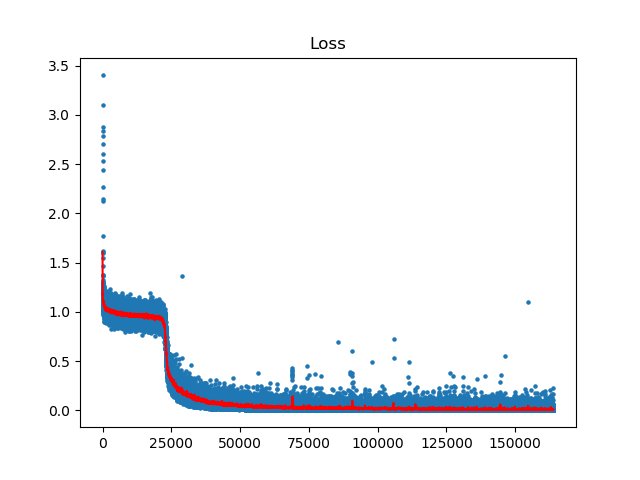

In [15]:
loss = []
with open(Path('results/example-loss.txt')) as f:
    for line in f:
        loss.append(float(line[6:]))
loss = np.array(loss)

plot(loss, 'Loss')

The above loss curve looks pretty typical for our model.

We get a very quick drop in the loss as our model learns some answers are ridiculous. For example, the `query_color` module should never output an answer that isn't a color and `count` should never output an answer that's not a number.

We then begin learning useful attentions, which lead to a rapid decrease in the loss, following which we see a smooth decrease toward zero.

Let's read in our accuracy next


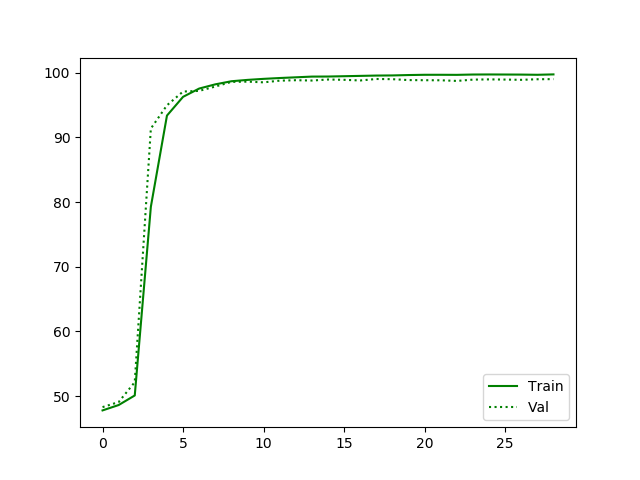

[ 47.78  48.61  50.09  79.28  93.39  96.29  97.57  98.22  98.7   98.91
  99.07  99.2   99.31  99.42  99.43  99.48  99.53  99.58  99.6   99.66
  99.7   99.7   99.69  99.74  99.75  99.74  99.73  99.7   99.76]
[ 48.29  49.07  52.15  91.38  94.98  97.11  97.21  97.88  98.6   98.64
  98.53  98.79  98.86  98.81  98.97  98.92  98.82  99.05  99.02  98.88
  98.86  98.85  98.75  98.95  98.99  98.96  98.92  99.01  99.03]
Highest validation accuracy: 99.05


In [16]:
train_acc = []
val_acc = []
with open(Path('results/example-acc.txt')) as f:
    for line in f:
        train_acc.append(float(line[-8:-3]))
        val_acc.append(float(f.readline()[-8:-3]))
    
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)

x = range(len(train_acc))
fig, ax = plt.subplots()
ax.plot(x, train_acc, label='Train', c='g')
ax.plot(x, val_acc, label='Val', c='g', ls=':')
ax.legend()

print(train_acc)
print(val_acc)
print('Highest validation accuracy: {}'.format(val_acc.max()))

We see our model learns remarkably quickly. After the first couple epochs, the model is refining attentions, having learned generally what they should be doing. Again, note that the training accuracy is not quite a correct measure of training performance since it is computed during training. This is why training accuracy is slightly below validation accuracy for a while.